In [1]:
import numpy as np
import cvxopt as co

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import sklearn.cluster as cl

In [4]:
from niidbox.tcrfr_qp import TCRFR_QP
from niidbox.tcrfr_lbpa import TCRFR_lbpa
from niidbox.tcrfr_lbpa_iset import TCRFR_lbpa_iset

In [5]:
from niidbox.utils import profile, print_profiles

In [6]:
FRAC_LBLD_DATA = 0.2

In [7]:
data = np.load('niidbox-data/data_smiley.npz')
x = data['x']
y = data['y']
z = data['latent']
width = data['width']
height = data['height']
exms = x.shape[0]

In [8]:
kmeans = cl.KMeans(n_clusters=2, init='random', n_init=4, max_iter=100, tol=0.0001)
kmeans.fit(x)

KMeans(copy_x=True, init='random', max_iter=100, n_clusters=2, n_init=4,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

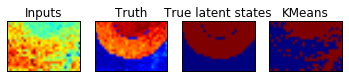

In [9]:
plt.subplot(1, 4, 1)
plt.imshow(x[:, 0].reshape((height, width), order='C'))
plt.title('Inputs')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 4, 2)
plt.imshow(y.reshape((height, width), order='C'))
plt.title('Truth')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 4, 3)
plt.imshow(z.reshape((height, width), order='C'))
plt.title('True latent states')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 4, 4)
plt.imshow(kmeans.labels_.reshape((height, width), order='C'))
plt.title('KMeans')
plt.xticks([])
plt.yticks([])
plt.show()

In [10]:
linds = np.random.permutation(exms)[:np.int(FRAC_LBLD_DATA*exms)]

In [11]:
A = co.spmatrix(0, [], [], (exms, exms), tc='d')
for k in range(1, 4):
    for i in range(height):
        for j in range(width):
            idx = i*width + j
            idx1 = (i+k)*width + j
            idx2 = i*width + j + k
            if k == 1 or (k>1 and idx in linds) or (k>1 and idx1 in linds) or (k>1 and idx2 in linds):
                if i < height-k:
                    A[idx, idx1] = 1
                    A[idx1, idx] = 1
                if j < width-k:
                    A[idx, idx2] = 1
                    A[idx2, idx] = 1

In [12]:
%%capture on
qp   = TCRFR_QP(x.T.copy(), y[linds].copy(), linds, states=2, A=A, reg_theta=0.85, trans_sym=[1])
qp.fit(use_grads=False)

True

In [14]:
%%capture on
lbpa = TCRFR_lbpa(x.T, y[linds], linds,  states=2, A=A, 
                  reg_gamma=1., reg_theta=0.95, trans_sym=[1])
lbpa.verbosity_level = 2
lbpa.fit(use_grads=False, auto_adjust=True)

True

In [15]:
isets = [np.arange(0, y.size)]

In [16]:
%%capture on
lbpa_iset = TCRFR_lbpa_iset(isets, x.T, y[linds], linds,  states=2, A=A, 
                  reg_gamma=1., reg_theta=0.95, trans_sym=[1])
lbpa_iset.verbosity_level = 2
lbpa_iset.fit(use_grads=False, auto_adjust=True)

True

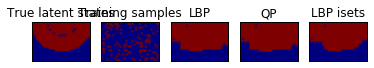

In [17]:
plt.subplot(1, 5, 1)
plt.imshow(z.reshape((height, width), order='C'))
plt.title('True latent states')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 5, 2)
lbls = np.zeros(exms)
lbls[linds] = 1
plt.imshow(lbls.reshape((height, width), order='C'))
plt.title('Training samples')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 5, 3)
plt.imshow(lbpa.latent.reshape((height, width), order='C'))
plt.title('LBP')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 5, 4)
plt.imshow(qp.latent.reshape((height, width), order='C'))
plt.title('QP')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 5, 5)
plt.imshow(lbpa_iset.latent.reshape((height, width), order='C'))
plt.title('LBP isets')
plt.xticks([])
plt.yticks([])

plt.show()